In [1]:
!which latex

/usr/bin/latex


In [2]:
import sys
import traceback
from os.path import join as joinp

import numpy as np

import sklearn.metrics

from matplotlib import pyplot as plt

from tqdm import tqdm

In [3]:
sys.path.append('../src/')

In [6]:
k = lambda x, beta: 1. / (1 + np.exp(-beta * x))

In [7]:
import os
import seaborn as sb

In [8]:
def generate_dynamics(N, T, interactions_per_timestep=1, mu=0.5, eps=.25, beta=50, x0=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    sigmoid = lambda x: 1. / (1 + np.exp(-beta * x))
    
    if x0 is None:
        x0 = np.random.uniform(size=N) * 2 - 1
        print(x0)
    
    u_v_t_w = []
    
    t = 0
    X = [x0]
    count = [0]
    for t in range(T):
        xt = X[-1]
        ct = 0
        xtp1 = xt.copy()
        for _ in range(interactions_per_timestep):
            i = np.random.randint(N)
            while True:
                j = np.random.randint(N)
                if i != j: break

            dist = np.abs(xt[i] - xt[j])
            p = sigmoid(eps-dist)
            extraction = np.random.uniform()
            if p>=extraction:
                if dist>eps:
                    ct+=1
                xtp1[i] += mu * (xt[j] - xt[i])
                xtp1[j] += mu * (xt[i] - xt[j])
                u_v_t_w.append( (i, j, t, 1) )
            else:
                u_v_t_w.append( (i, j, t, 0) )
            xtp1 = np.clip(xtp1, -1, 1)
        
        X.append(xtp1)
        count.append(ct)

    X = np.vstack(X)

    return u_v_t_w, X, count

# Learnable BCM

## Many trials, Complete derivative in $\beta, \epsilon$, N=100

In [9]:
N = 100
T = 10000
mu = 0.5
eps = 0.25
beta = 60

In [10]:
plt.rcParams['text.usetex'] = True

Text(0.5, 0, '$\\lambda$')

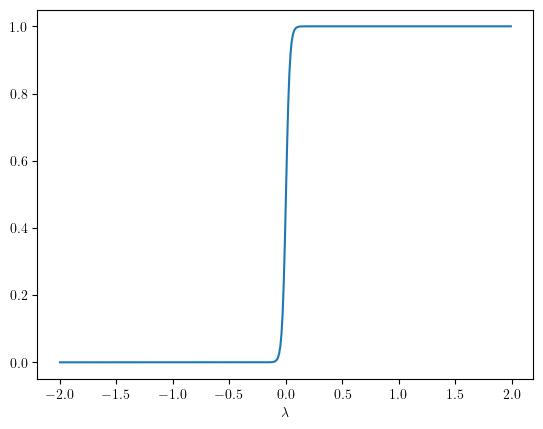

In [11]:
plt.plot(np.arange(-2, 2, 0.01), [k(x, beta) for x in np.arange(-2, 2, 0.01)])
plt.xlabel(r'$\lambda$')

In [12]:
# beta_range = np.linspace(59, 61, 3)
eps_range = np.linspace(0., 2., 101)

seed_list = []
all_res = []

seed = 0
np.random.seed(seed)
x0 = np.random.uniform(size=N) * 2 - 1

for trial in tqdm(range(100)):
    # print(f"trial {trial+1}/100")
    while True:
        seed = np.random.randint(0, 3000)
        if seed not in seed_list:
            break
            
    seed_list.append(seed)

    Et, X, _ = generate_dynamics(N, T, interactions_per_timestep=1, mu=mu, eps=eps, beta=beta, x0=x0, seed=seed)
    Et = np.array(Et)
    sizeE = np.sum(Et[Et[:, -1]==1, -1], axis=0)

    res = []
    for eps_hat in eps_range:
        single_res = []
        # for beta_hat in beta_range:
        beta_hat = beta
        s = 0
        sk = 0
        sdist = 0
        for i, j, t, state in Et:
            dist = np.abs(X[t, i]-X[t, j])
            s+=k(eps_hat-dist, beta_hat)
            sk+=k(eps_hat-dist, beta_hat)*dist
            if state == 1:
                sdist+=dist

        single_res.append([eps_hat, beta_hat, s-sizeE, sk-sdist, eps*(s-sizeE)-sk+sdist])
        res.append(single_res)
    all_res.append(res)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:27<00:00,  5.67s/it]


In [13]:
all_res = np.array(all_res)

In [15]:
sb.set_theme(style="ticks", context="notebook", font="Arial")

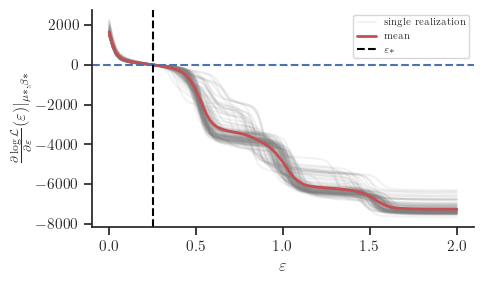

In [17]:
plt.figure(figsize=(5, 3))
plt.plot(eps_range, -all_res[:, :, 0, 2].T, c='grey', alpha=.1, label='single realization');
plt.plot(eps_range, -all_res[:, :, 0, 2].mean(axis=0), c='r', lw=2, label='mean');
plt.axhline(0, c='b', ls='--')
plt.axvline(eps, c='black', ls='--', label=r'$\varepsilon*$')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[-3:], labels[-3:], loc='best', fontsize=7)
plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'$\frac{\partial\log\mathcal{L}}{\partial\varepsilon}(\varepsilon)|_{\mu*, \beta*}$')

sb.despine()
plt.tight_layout()
plt.savefig(os.path.join('../', 'figs', f"{N}_{T}_{eps}_{beta}_{mu}_dL_deps.pdf"))